# Data Analysis for the Smart Society - Lab 1 

The data has already been segmented using Matlab into windows of 3 seconds in length with an overlap of 50% (the code is found in GenerateSegmentedData.m) . The windows that contained mixed labels were removed from the dataset. The original raw data contained 5 sources. They were the axis Z transformed accelerometer data, the module of the axis XY transformed accelerometer data and the transformed gyroscope data for each of the X, Y and Z axis. From this a set of 36 features were then extracted using the data from each window. The features extracted were: 
- The mean of each of the columns (accelz_mean, accelxy_mean, gyrox_mean, gyroy_mean,gyroz_mean)
- The standard deviation of the columns (accelz_std, accelxy_std, gyrox_std, gyroy_std, gyroz_std)
- The root mean square of the columns (accelz_rms, accelxy_rms, gyrox_rms, gyroy_rms, gyroz_rms) 
- The max-min difference for each column (accelz_minmax, accelxy_minmax, gyrox_minmax, gyroy_minmax, gyroz_minmax)
- The spectral energy of each column (accelz_speceng, accelxy_speceng, gyrox_speceng, gyroy_speceng, gyroz_speceng)
- The spectral entropy of each column (accelz_ent, accelxy_ent, gyrox_ent, gyroy_ent, gyroz_ent)
- The Signal Magnitude Area of the gyroscope (SMA)
- The correlation between the accelerometer components (accelxyz_corr)
- The correlation between the gyroscope components (gyroxy_corr, gyroxz_corr, gyroyz_corr)
- The average tilt angle of the gyroscope (tilt_angle)
    
    
The formulas used to calculate the features can be found in

    - Suto, Jozsef & Oniga, Stefan & Pop, Petrica. (2017). Feature Analysis to Human Activity Recognition. International Journal of Computers, Communications & Control (IJCCC). 12. 116-130. 10.15837/ijccc.2017.1.2787.
    
    - Maziewski, Przemek & Kupryjanow, Adam & Kaszuba, K & Czyzewski, A. (2009). Accelerometer signal pre-processing influence on human activity recognition. 95 - 99.


## Loading the processed data 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Load in the data files to pandas
data1 = pd.read_csv("data1.csv", sep = ";")
data2 = pd.read_csv("data2.csv", sep = ";")
data3 = pd.read_csv("data3.csv", sep = ";")
data4 = pd.read_csv("data4.csv", sep = ";")
data5 = pd.read_csv("data5.csv", sep = ";")
data6 = pd.read_csv("data6.csv", sep = ";")
data7 = pd.read_csv("data7.csv", sep = ";")
data8 = pd.read_csv("data8.csv", sep = ";")

# Load in the test files to pandas
test1 = pd.read_csv("test1.csv", sep = ";")
test2 = pd.read_csv("test2.csv", sep = ";")

data_list = [data1, data2, data3, data4, data5, data6, data7, data8]

X_list = [data1.iloc[:,0:36], data2.iloc[:,0:36], data3.iloc[:,0:36], data4.iloc[:,0:36], data5.iloc[:,0:36], data6.iloc[:,0:36], data7.iloc[:,0:36], data8.iloc[:,0:36]]
Y_list = [data1.iloc[:,[36]], data2.iloc[:,[36]], data3.iloc[:,[36]], data4.iloc[:,[36]], data5.iloc[:,[36]], data6.iloc[:,[36]], data7.iloc[:,[36]], data8.iloc[:,[36]]]

all_x = pd.concat(X_list, ignore_index = True)
all_y = pd.concat(Y_list, ignore_index = True)


## Exploratory Analysis 

Next I am going to take a look at the data to inspect which proportion of the segments correspond to each activity. 

<BarContainer object of 5 artists>

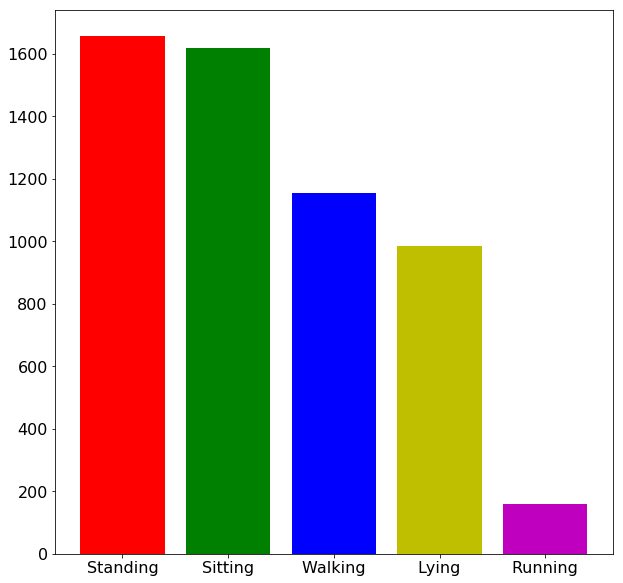

In [3]:
# First we must concatenate the label data together into one pandas dataframe 
all_labels = pd.concat(Y_list, ignore_index=True)

activity_count = all_labels['label'].value_counts()
activity_names = ['Standing', 'Sitting', 'Walking','Lying', 'Running']
plt.rcParams.update({'figure.figsize': [10, 10], 'font.size': 16})
plt.bar(activity_names, activity_count, color = ('r', 'g', 'b', 'y', 'm') )


As we can see from the the bar chart there are a lot more instances of standing and sitting than there are for running. It may be beneficial to keep this in mind when training models.

### Checking for Correlation between the features 

To continue the exploratory analysis of the features it is worthwhile to look at the correlation between the extracted features.

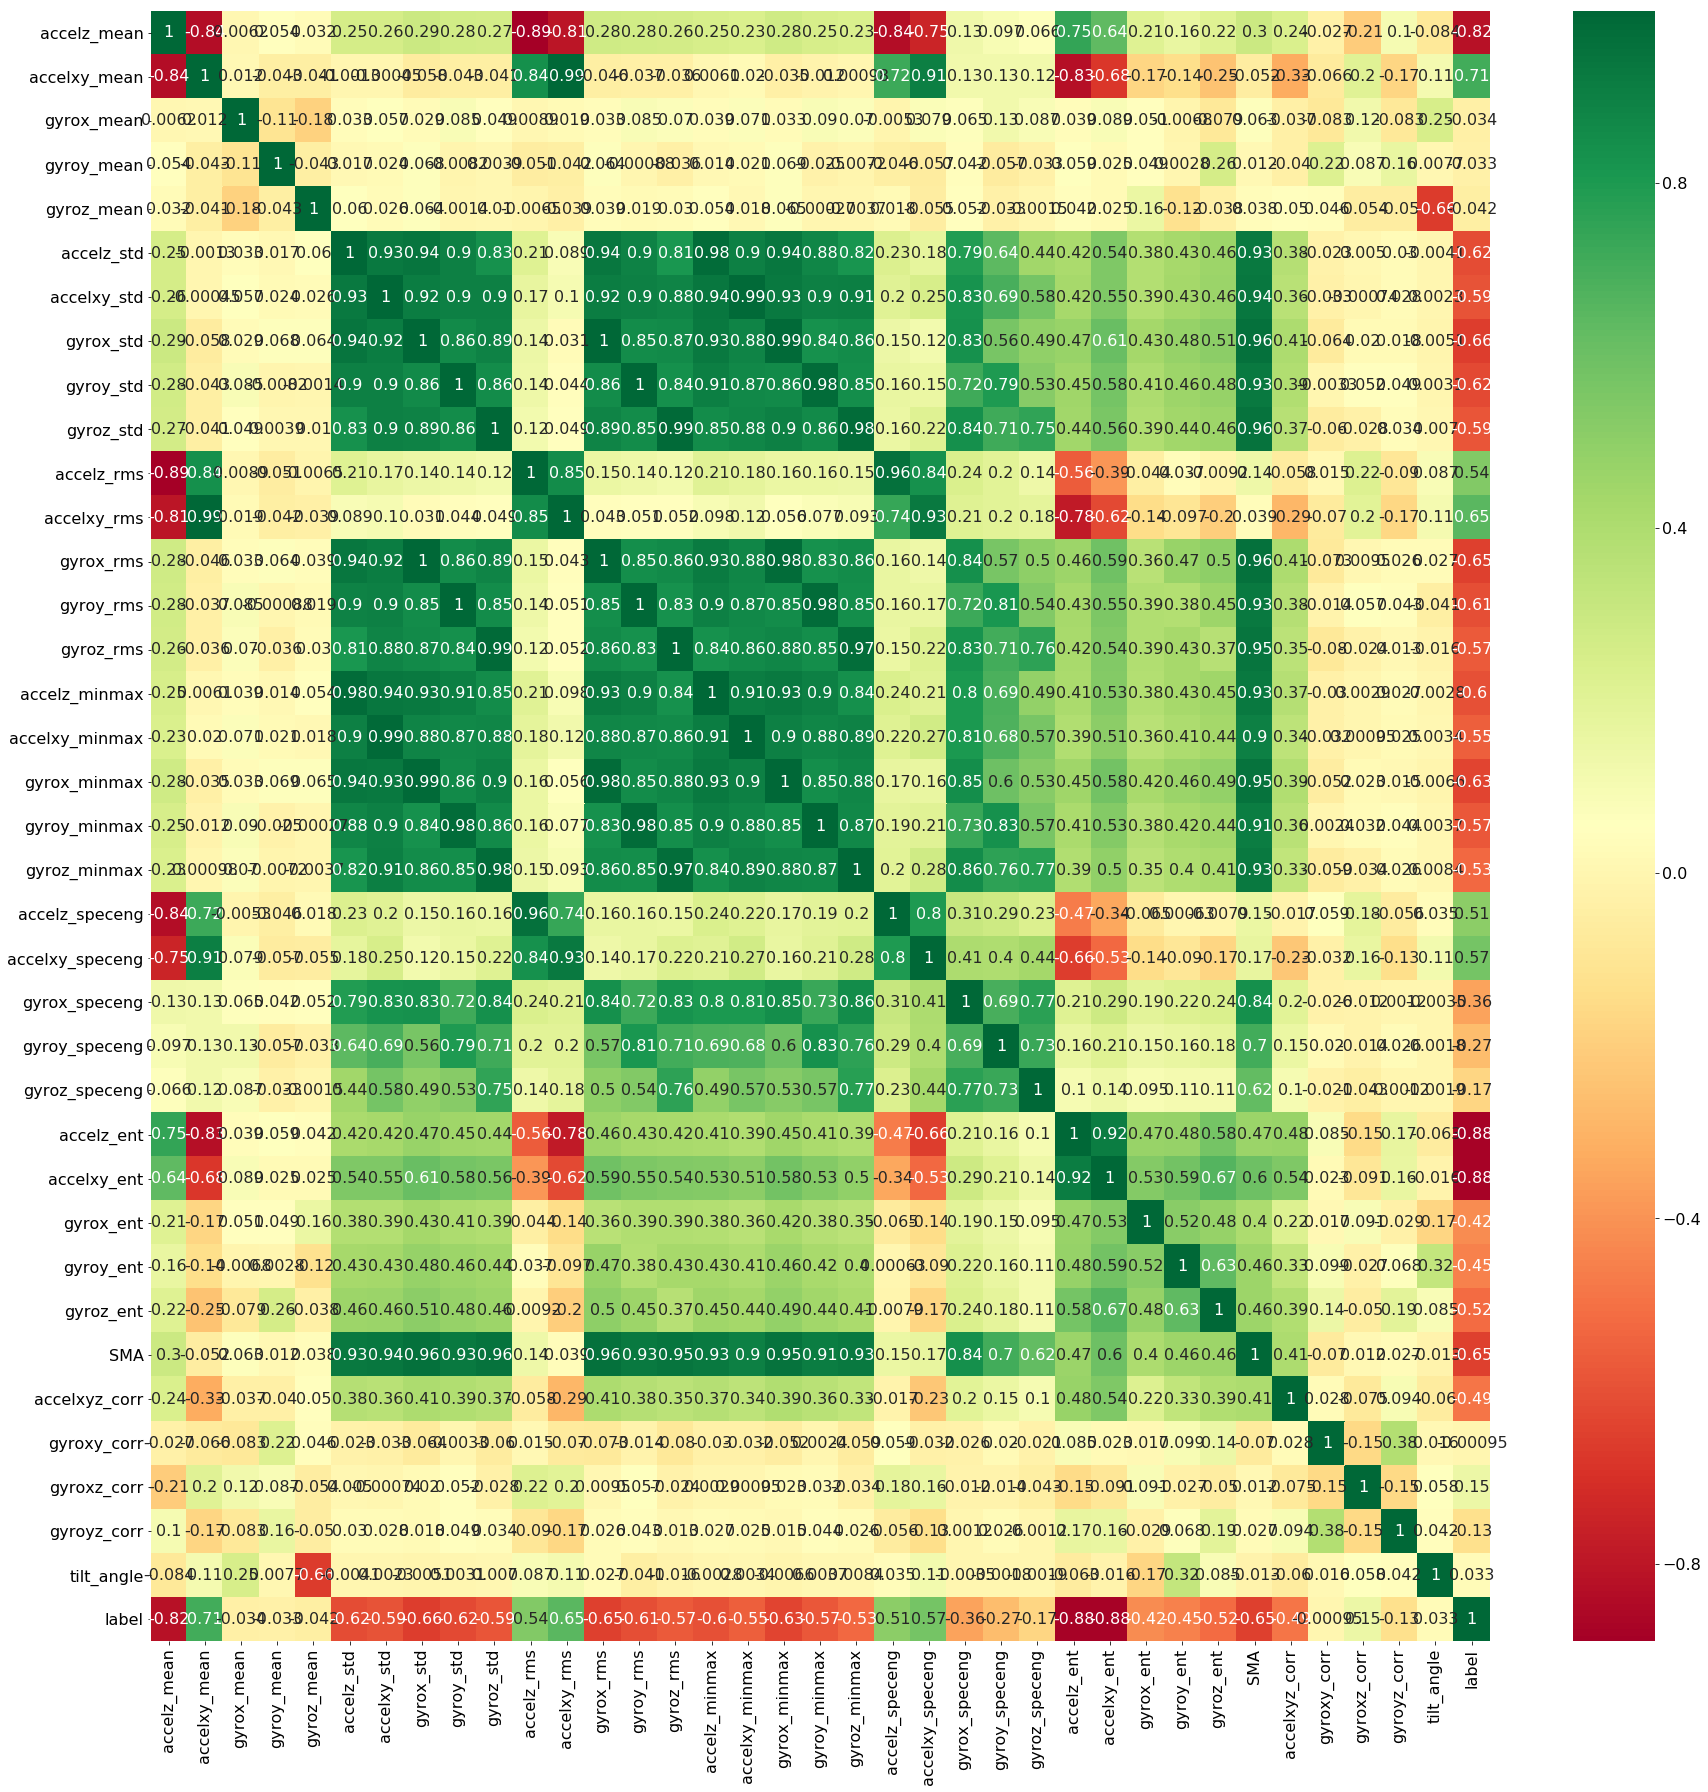

In [4]:
import seaborn as sns
from sklearn import preprocessing

all_data = pd.concat(data_list, ignore_index=True)

x = all_data.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
all_data_norm = pd.DataFrame(x_scaled, columns=all_data.columns)

corrmat = all_data_norm.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(30,30))
#plot heat map
g=sns.heatmap(all_data_norm[top_corr_features].corr(),annot=True,cmap="RdYlGn")

There are a number of features, particularly accelz_mean, accelz_ent and accelxy_ent that seem to be very correlated with the activity label, however we can see that a lot of the features are quite correlated between eachother and so feature selection or dimensionality reduction will likely benefit the when fitting the models 

The models I am going to consider for our dataset are Random Forest, K Nearest Neighbors and Support Vector Machines

## Random Forest

The first model that I am going to try to fit to our data is by using Random Forest. As previously mentioned a lot of the features appear to be highly correlated with eachother so in order to improve the performance of the model I will try two different approaches for feature selection.

First I will try feature selection using Recursive Feature Selection with Leave One Out Cross Validation. The 8 data files will be used for cross validation when training the model, each time leaving out one of the data files. In order to ensure that our feature selection is not biased (by having access to all of the data before I conduct the LOOCV that we will used for hyperparmaeter tuning) I will use nested cross validation. In this case the feature selection procedure will be carried out on each of the data files separately. The features that are chosen most frequently by the cross validation models will then be used for the hyperparameter tuning cross-validation loop. 

The procedure used for feature selection for our Random Forest model will be Principal Componenet Analysis. I will look at the number of principal components I can use to explain a large portion of the variance of the data, apply this subsection of the data to the Random Forest and then use LOOCV again for the hyperparameter tuning. The benefit of PCA is that it will reduce the dimensionality of our dataset and also cause colinear features to be contained within on PCA component. 

Since I have discovered that the dataset is also imbalanced I will consider this in my modelling and investigate whether resampling my data will improve the performance of my models

### Random Forest with RFE for feature selection 

The first version of Random Forest I will implement is using RFE for feature selection and not considering resampling to balance the response occurances of the dataset

To get an idea of how many features I should take I first fit a Random Forest classifier with LOOCV between the files and check which features are the top features repeatedly

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

# Select the most important features using RFE with LOOCV on each data file

rf = RandomForestClassifier(n_estimators=100, random_state= 0)

top_features = []

# LOOCV loop for feature selection 
for i in range(0,8):
    #Gather training files
    train_x = [x for j,x in enumerate(X_list) if j!=i]
    train_y = [y for j,y in enumerate(Y_list) if j!=i]
    
    #Concatenate training files
    train_x = pd.concat(train_x, ignore_index = True)
    train_y = pd.concat(train_y, ignore_index = True)
    
    #Run RFE with the Random Forest
    feat_selector = RFE(rf, step = 1)
    features = feat_selector.fit(train_x, train_y.values.ravel())
   
    
    selected_feat= train_x.columns[(features.get_support())]
    selected_feat_df = pd.DataFrame(selected_feat)
    
    #Add the selected features to the top features list
    top_features.append(selected_feat_df)
    
#Get a count of which features were selected most often  
top_features = pd.concat(top_features, ignore_index=True)
features_count = top_features[0].value_counts()
print(features_count)

accelz_rms         8
accelz_speceng     8
accelxy_rms        8
SMA                8
accelz_mean        8
accelz_ent         8
gyroz_std          8
accelxy_mean       8
accelz_minmax      8
accelxy_speceng    8
gyrox_std          8
accelz_std         8
gyroy_rms          7
gyroy_speceng      7
gyroy_std          6
gyrox_minmax       6
accelxy_ent        5
gyroz_minmax       4
gyroz_speceng      3
gyroz_rms          3
tilt_angle         2
accelxy_std        2
gyrox_speceng      2
gyrox_rms          1
Name: 0, dtype: int64


From this I will select the features that were the top features on at least four occasions, therefore they were in the top features half of the time. This takes us from originally 36 features down to just 18. Using these features I will then run LOOCV again in order to conduct hyperparameter tuning for the dataset and access the error rate of the Random Forest Classifier. 

I will now create a pipeline and use a nested loop with RandomizedSearchCV in order to tune the hyperparameters

In [6]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline


cv_evaluation = KFold(n_splits = 8, shuffle = False , random_state = 0)

clf = Pipeline([
  ('feature_selection', RFE(RandomForestClassifier(random_state=0), step = 1, n_features_to_select = 18)),
  ('randomforestclassifier', RandomForestClassifier(random_state= 0))
])

random_grid = {'randomforestclassifier__n_estimators': [100,200,300],
           'randomforestclassifier__max_depth': list(range(2,20,2)),
           'randomforestclassifier__min_samples_split': list(range(2,20,2)),
           'randomforestclassifier__bootstrap': [True,False]
          }

rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid,
                           n_iter = 100, cv = cv_evaluation, random_state=0, n_jobs = -1, verbose = -1)

rf_random.fit(all_x, all_y.values.ravel())


print(rf_random.best_params_, rf_random.best_score_)




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 12.4min finished
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 

{'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__max_depth': 4, 'randomforestclassifier__bootstrap': False} 0.9693273542600896


The following function plots a confusion matrix for each of the classes and is found in the sklearn documentation

In [7]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=["Running","Walking","Standing","Sitting","Lying"], yticklabels=["Running","Walking","Standing","Sitting","Lying"],
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


[0.95839311 0.99569584 1.         0.86944046 0.98278336 0.95265423
 0.99713056 0.99856322]
0.9693325974208018
Normalized confusion matrix


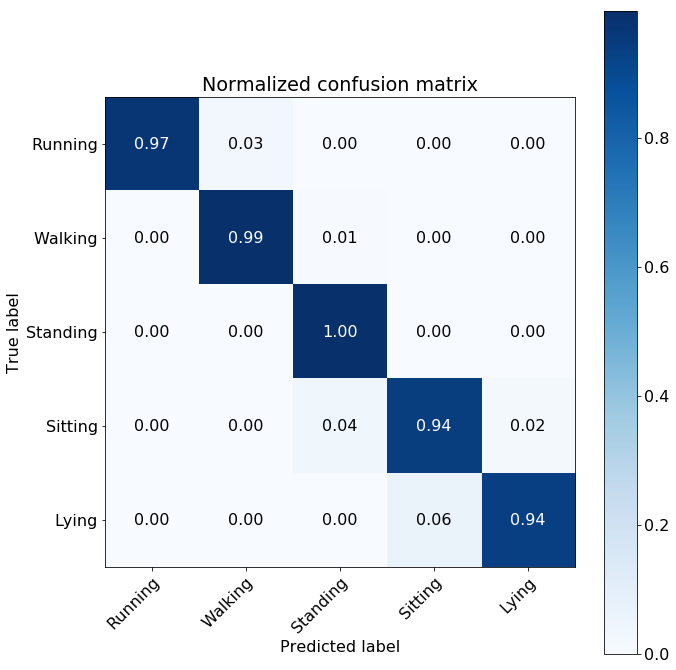

In [8]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

pipeline = Pipeline([
  ('feature_selection', RFE(RandomForestClassifier(random_state=0), step = 1, n_features_to_select = 18)),
  ('randomforestclassifier', rf_random.best_estimator_)
])

score = cross_val_score(pipeline, all_x, all_y, scoring = 'accuracy', cv = cv_evaluation, n_jobs = -1, verbose = 0)
print(score)
print(score.mean())


predictions = cross_val_predict(pipeline, all_x, all_y, cv = cv_evaluation, n_jobs = -1, verbose = 0)

plot_confusion_matrix(all_y, predictions, normalize=True,
                      title='Normalized confusion matrix')

plt.show()



As we can see from the results the best random forest classifier found using randomized grid cross-validation for the hyperparameter tuning returns an very good classifier with an accuracy of 96.9%. 

Following I looked at a confusion matrix to see the accuracy of the classifier with each of the individual activities. From the confusion matrix we can see that the classifier identified all the true standing cases however made some mistakes with the res of activities. Unsurprisingly there seems to be some misclassification between sitting and lying and also between running and walking. This makes sense as these activities are quite similar. 

To try to improve the classifier I will next look at adding weights to classes as the proportions of instances are not equal within the dataset.

### Random Forest Classifier with weighted classes 

In [9]:
rf_balanced = RandomForestClassifier(random_state=0, class_weight = 'balanced')

clf = Pipeline([
  ('feature_selection', RFE(rf_balanced, step = 1, n_features_to_select = 18)),
  ('randomforestclassifier', rf_balanced)
])


rf_random_bal = RandomizedSearchCV(estimator = clf, param_distributions = random_grid,
                           n_iter = 100, cv = cv_evaluation, random_state=0, n_jobs = -1, verbose = -1)

rf_random_bal.fit(all_x, all_y.values.ravel())


print(rf_random_bal.best_params_, rf_random_bal.best_score_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 12.0min finished
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 

{'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_split': 8, 'randomforestclassifier__max_depth': 4, 'randomforestclassifier__bootstrap': True} 0.968609865470852


[0.95982783 0.98995696 0.99856528 0.8723099  0.9784792  0.94835007
 0.99713056 1.        ]
0.9680774748923959
Normalized confusion matrix


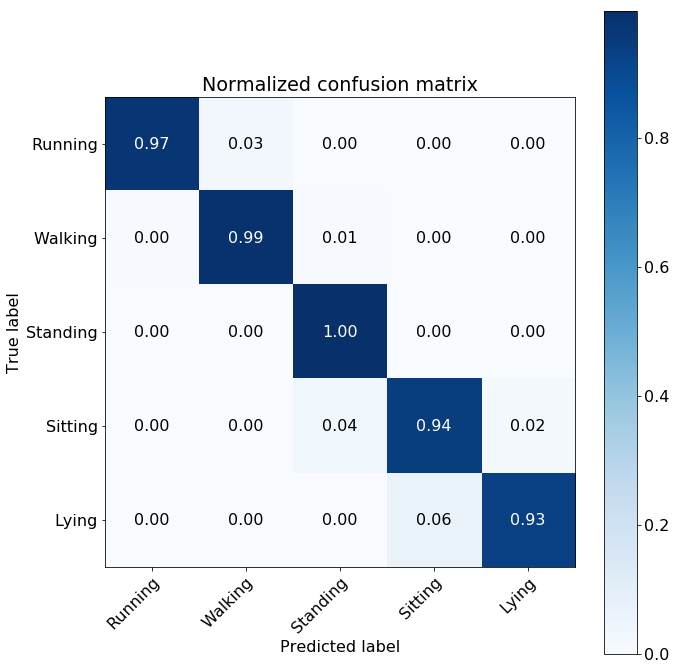

In [10]:
pipeline_bal = Pipeline([
  ('feature_selection', RFE(RandomForestClassifier(random_state=0), step = 1, n_features_to_select = 18)),
  ('randomforestclassifier', rf_random_bal.best_estimator_)
])

score_bal = cross_val_score(pipeline_bal, all_x, all_y, scoring = 'accuracy', cv = cv_evaluation, n_jobs = -1, verbose = 0)
print(score_bal)
print(score_bal.mean())


predictions = cross_val_predict(pipeline_bal, all_x, all_y, cv = cv_evaluation, n_jobs = -1, verbose = 0)

plot_confusion_matrix(all_y, predictions, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

We find that adding weights to the classes actually worsens the classifier slightly with it now having a accuracy of 96.8%. We can also see from the confusion matrix that the accuracy of the classifier when classifing lying has decreased slightly.

### Random Forest Classifier with PCA 

The final Random Forest Classifier that I am going to try to model is one which will use Principal Component Analysis instead of Recursive Feature Elimination for the feature selection portion of the modelling. As previously mentioned with PCA we can reduce the dimensionality of the data while keeping the majority of the information regarding the variance of the dataset. Additionally the colinearity will be removed between the features as colinear features will be placed in the same principal component

In [11]:
from sklearn.decomposition import PCA 

pca = PCA(n_components = 10)
pca.fit(all_x)

np.cumsum(pca.explained_variance_ratio_)

array([0.90140532, 0.99741735, 0.99974633, 0.99990056, 0.999997  ,
       0.99999922, 0.99999957, 0.99999975, 0.99999981, 0.99999985])

As we can see, with the first 3 principal components we can explain 99.9% of the variance explained by the dataset

In [12]:
pca_rf = PCA(n_components=3)
pca_rf.fit(all_x)
x_pca = pca_rf.transform(all_x)

In [13]:
cv_evaluation = KFold(n_splits = 8, shuffle = False , random_state = 0)

rf = RandomForestClassifier(random_state= 0)


random_grid = {'n_estimators': [100,200,300],
           'max_depth': list(range(2,20,2)),
           'min_samples_split': list(range(2,20,2)),
           'bootstrap': [True,False]
          }

rf_pca = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                           n_iter = 100, cv = cv_evaluation, random_state=0, n_jobs = -1, verbose = 0)

rf_pca.fit(x_pca, all_y.values.ravel())


print(rf_pca.best_params_, rf_pca.best_score_)

{'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 6, 'bootstrap': True} 0.9668161434977578


[0.95982783 0.99569584 1.         0.8723099  0.98421808 0.93687231
 0.99713056 1.        ]
0.9682568149210904
Normalized confusion matrix


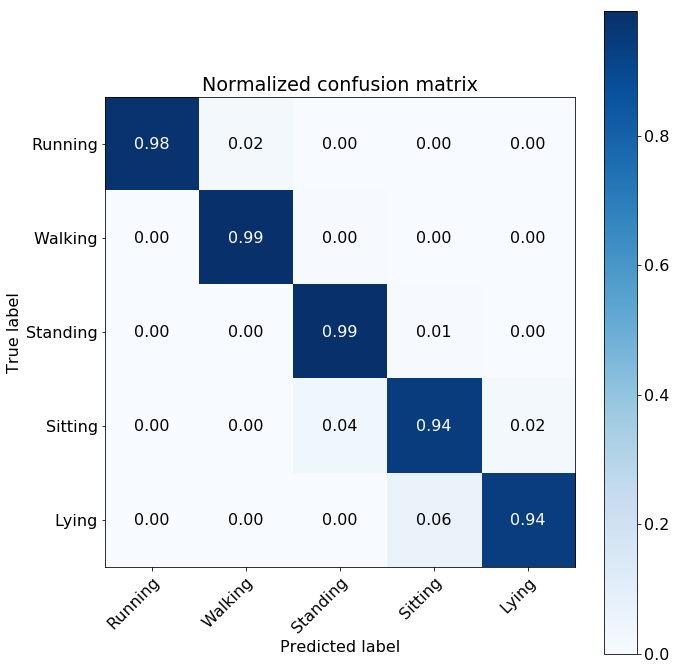

In [14]:


score_pca = cross_val_score(rf_pca.best_estimator_, all_x, all_y, scoring = 'accuracy', cv = cv_evaluation, n_jobs = -1, verbose = 0)
print(score_pca)
print(score_pca.mean())


predictions = cross_val_predict(rf_pca.best_estimator_, all_x, all_y, cv = cv_evaluation, n_jobs = -1, verbose = 0)

plot_confusion_matrix(all_y, predictions, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

It appears that the Random Forest Classifier with PCA also performs slightly worse than the original Random Forest model with an accuracy of 96.8% accuracy. However the classifer still performs rather impressively when we consider that we have reduced the dimensionality of the data from 36 components down to just 3.

##  K Nearest Neighbors

The next algorithm I am going to use to model the data is K Nearest Neighbors. For this algorithm I am going to fit two different models once again. One using RFE for feature selection and the other using PCA as before. For KNN, as the distance between the points determine the final classification, the results can be improved by first scaling the features. Also for the KNN models i used GridSearchCV instead of RandomizedGrid as there are less hyperparameters to fit. 

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV 


knn_pipeline = Pipeline([ 
  ('scaling', StandardScaler()),
  ('feature_selection', RFE(RandomForestClassifier(random_state=0), step = 1, n_features_to_select = 18)),
  ('knnclassifier', KNeighborsClassifier())
])

paramgrid = {'knnclassifier__n_neighbors': list(range(2,25,1)),
           'knnclassifier__weights': ['uniform', 'distance'],
          }

knn = GridSearchCV(estimator = knn_pipeline, param_grid = paramgrid,
                          cv = cv_evaluation, n_jobs = -1, verbose = -1)

knn.fit(all_x, all_y.values.ravel())


print(knn.best_params_, knn.best_score_)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 368 out of 368 | elapsed:  3.8min finished
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\niall\Anaconda3\lib\site-pa

{'knnclassifier__n_neighbors': 10, 'knnclassifier__weights': 'uniform'} 0.962152466367713


[0.97274032 0.94404591 0.98995696 0.8723099  0.9713056  0.93256815
 0.99713056 0.99712644]
0.959647978198849
Normalized confusion matrix


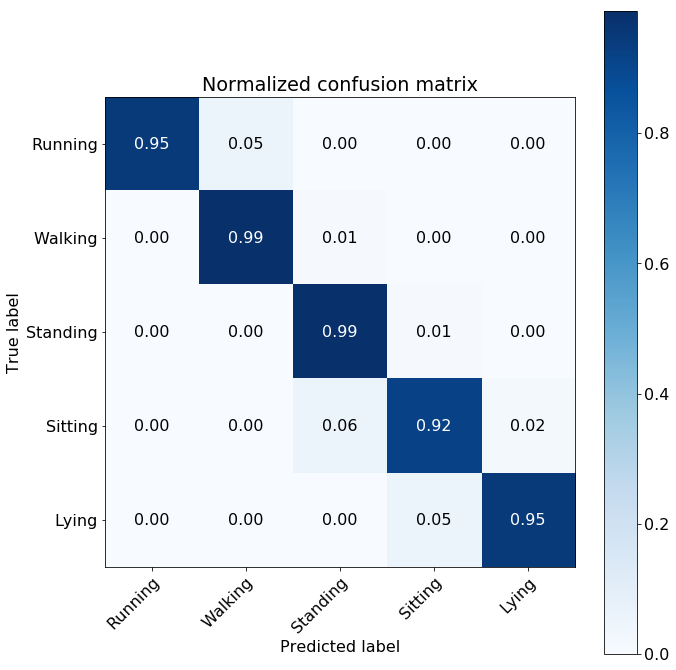

In [16]:
knn_score = cross_val_score(knn_pipeline, all_x, all_y, scoring = 'accuracy', cv = cv_evaluation, n_jobs = -1, verbose = 0)
print(knn_score)
print(knn_score.mean())


knn_predictions = cross_val_predict(knn_pipeline, all_x, all_y, cv = cv_evaluation, n_jobs = -1, verbose = 0)

plot_confusion_matrix(all_y, knn_predictions, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

The KNN classifier has an accuracy of 95.9%. In an attempt to improve the classifier I used SMOTE to over-sample the classes with less instances. As KNN uses the the number of closest neighbors to classify instances, under sampled classes may not be classified as accurately

### K Nearest Neighbors with SMOTE 

C:\Users\niall\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0.98938224 0.97779923 0.89671815 0.98552124 0.9980695  0.9942029
 0.98647343 0.9942029 ]
0.977796196817936
Normalized confusion matrix


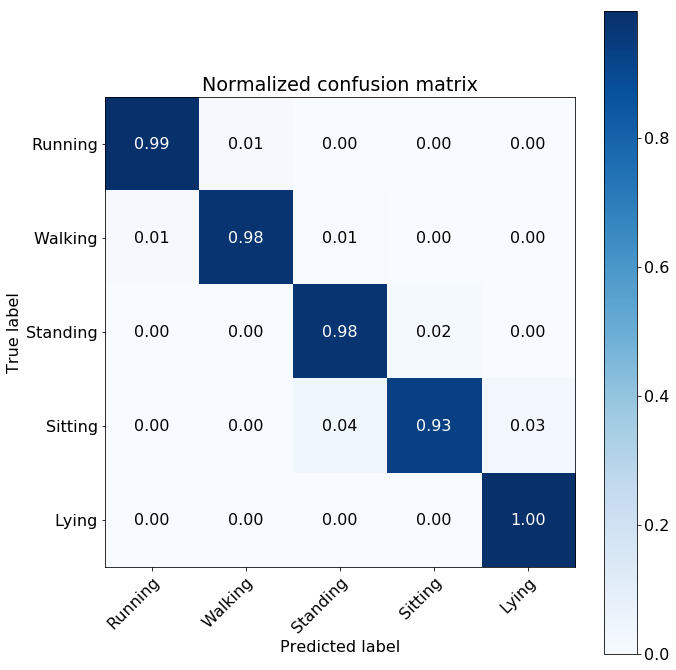

In [17]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state = 0)
x_res, y_res = sm.fit_resample(all_x, all_y)

knn_smote_score = cross_val_score(knn_pipeline, x_res, y_res, scoring = 'accuracy', cv = cv_evaluation, n_jobs = -1, verbose = 0)
print(knn_smote_score)
print(knn_smote_score.mean())


knn_smote_predictions = cross_val_predict(knn_pipeline, x_res, y_res, cv = cv_evaluation, n_jobs = -1, verbose = 0)

plot_confusion_matrix(y_res, knn_smote_predictions, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

When we used SMOTE we can see that the accuracy of the classifier improved to 97.7%. In addition to this, the class of "Running" which previously had much fewer instances compared to other classes improved from 95% correct classifications to 99%.

### K Nearest Neighbours with PCA 

Finally I once again fitted a KNN model but this time using PCA for dimensionality reduction. I once again used 3 components which as we found earlier contains 99.9% of the explained variance.

In [18]:

knn_pca_pipeline = Pipeline([ 
  ('scaling', StandardScaler()),
  ('pca', PCA(n_components = 3)),
  ('knnclassifier', KNeighborsClassifier())])

paramgrid = {'knnclassifier__n_neighbors': list(range(2,25,1)),
           'knnclassifier__weights': ['uniform', 'distance'],
          }

knn_pca = GridSearchCV(estimator = knn_pca_pipeline, param_grid = paramgrid,
                          cv = cv_evaluation, n_jobs = -1, verbose = 0)

knn_pca.fit(all_x, all_y.values.ravel())


print(knn_pca.best_params_, knn_pca.best_score_)



{'knnclassifier__n_neighbors': 23, 'knnclassifier__weights': 'uniform'} 0.9547982062780269


[0.94117647 0.9784792  0.91391679 0.84505022 0.95695839 0.92969871
 0.99856528 0.99712644]
0.9451214358746022
Normalized confusion matrix


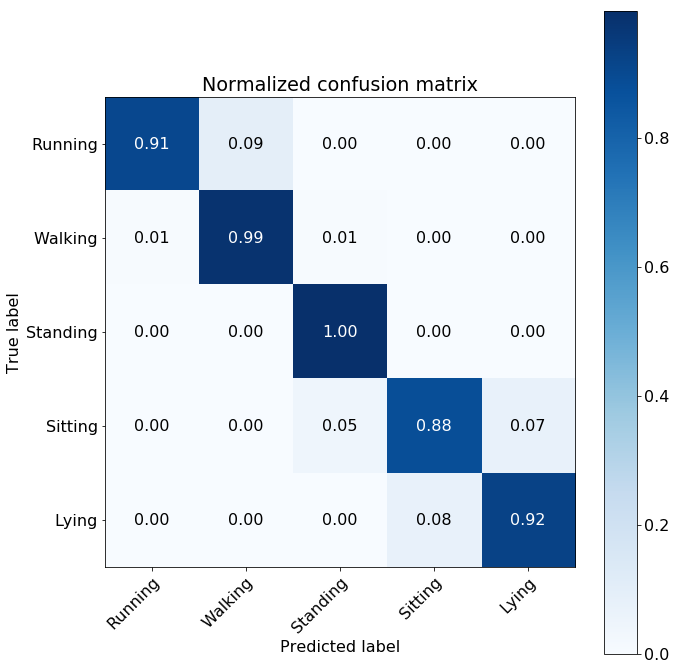

In [19]:
knn_pca_score = cross_val_score(knn_pca_pipeline, all_x, all_y, scoring = 'accuracy', cv = cv_evaluation, n_jobs = -1, verbose = 0)
print(knn_pca_score)
print(knn_pca_score.mean())


knn_pca_predictions = cross_val_predict(knn_pca_pipeline, all_x, all_y, cv = cv_evaluation, n_jobs = -1, verbose = 0)

plot_confusion_matrix(all_y, knn_pca_predictions, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

The PCA KNN classifier had an accuracy 94.5%, lower than the other two KNN classifiers. Looking at that confusion matrix some of the class accuracies are much lower than the others too eg Sitting has an accuracy of 88% and Running of 91%

### Support Vector Machines 

The final algorithm that I am going to look at is support vector machines. A selection of models will be fit the same as before with RFE and PCA. 

In [20]:
from sklearn.svm import SVC


svm_pipeline = Pipeline([ 
  ('scaling', StandardScaler()),
  ('feature_selection', RFE(RandomForestClassifier(random_state=0), step = 1, n_features_to_select = 18)),
  ('svc', SVC(random_state=0))
])

paramgrid = {'svc__C': list(range(1,100,10)),
             'svc__kernel': ['linear', 'rbf', 'sigmoid'],
             'svc__gamma' : [1,2,5,10, 'auto', 'scale']
          }

svm = GridSearchCV(estimator = svm_pipeline, param_grid = paramgrid,
                          cv = cv_evaluation, n_jobs = -1, verbose = -1)

svm.fit(all_x, all_y.values.ravel())


print(svm.best_params_, svm.best_score_)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 15.6min finished
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from

{'svc__C': 11, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'} 0.9730941704035875


[0.97417504 0.93543759 0.99713056 0.8723099  0.97704448 0.96126255
 0.99713056 0.99712644]
0.9639521388875147
Normalized confusion matrix


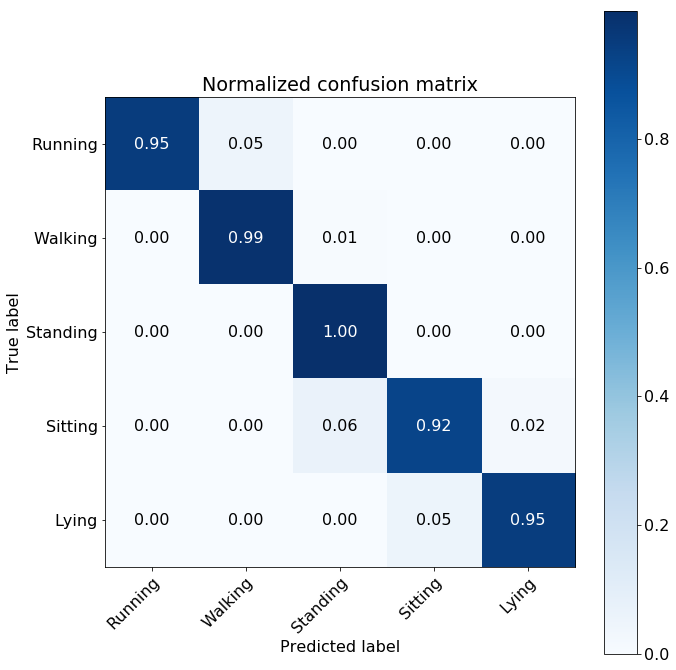

In [21]:
svm_score = cross_val_score(svm_pipeline, all_x, all_y, scoring = 'accuracy', cv = cv_evaluation, n_jobs = -1, verbose = 0)
print(svm_score)
print(svm_score.mean())


svm_predictions = cross_val_predict(svm_pipeline, all_x, all_y, cv = cv_evaluation, n_jobs = -1, verbose = 0)

plot_confusion_matrix(all_y, svm_predictions, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

The SVM classifier had an accuracy of 93.4%. To try to improve this, as with the KNN, I applied SMOTE to the data. 

### Support Vector Machine with SMOTE

[0.99324324 1.         0.88996139 0.98069498 0.9980695  0.99227053
 0.97874396 0.97971014]
0.9765867187062839
Normalized confusion matrix


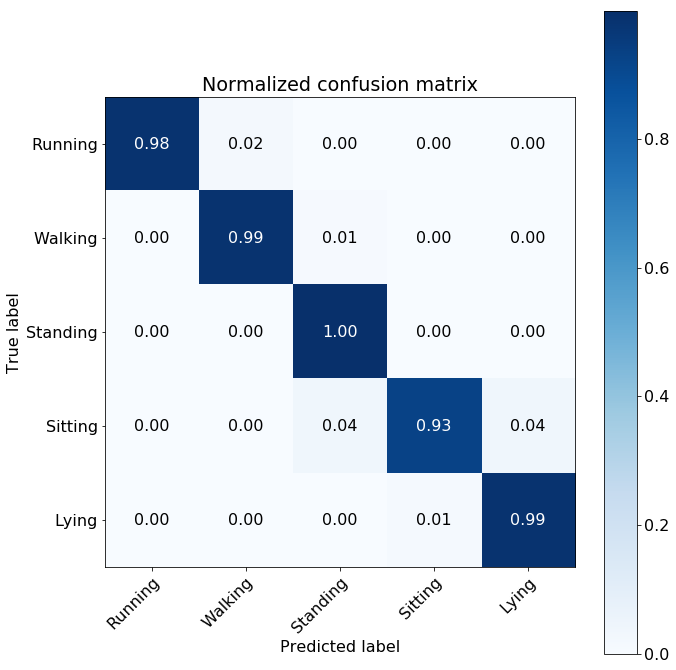

In [22]:
from sklearn.svm import SVC


svm_smote_score = cross_val_score(svm_pipeline, x_res, y_res, scoring = 'accuracy', cv = cv_evaluation, n_jobs = -1, verbose = 0)
print(svm_smote_score)
print(svm_smote_score.mean())


svm_smote_predictions = cross_val_predict(svm_pipeline, x_res, y_res, cv = cv_evaluation, n_jobs = -1, verbose = 0)

plot_confusion_matrix(y_res, svm_smote_predictions, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Applying SMOTE to the data before running the SVM classifier did improve the accuracy of the classifier improving from 93.6% to 97.6%

### Support Vector Machine with PCA 

In [23]:

svm_pca_pipeline = Pipeline([ 
  ('scaling', StandardScaler()),
  ('pca', PCA(n_components = 3)),
  ('svc', SVC(random_state=0))
])

paramgrid = {'svc__C': list(range(1,100,10)),
             'svc__kernel': ['linear', 'rbf', 'sigmoid'],
             'svc__gamma' : [1,2,5,10, 'auto', 'scale']
          }

svm_pca = GridSearchCV(estimator = svm_pca_pipeline, param_grid = paramgrid,
                          cv = cv_evaluation, n_jobs = -1, verbose = 0)

svm_pca.fit(all_x, all_y.values.ravel())


print(svm_pca.best_params_, svm_pca.best_score_)



{'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'} 0.9684304932735426


[0.94404591 0.99569584 0.99139168 0.86083214 0.96413199 0.94978479
 0.99856528 0.99856322]
0.9628763563878032
Normalized confusion matrix


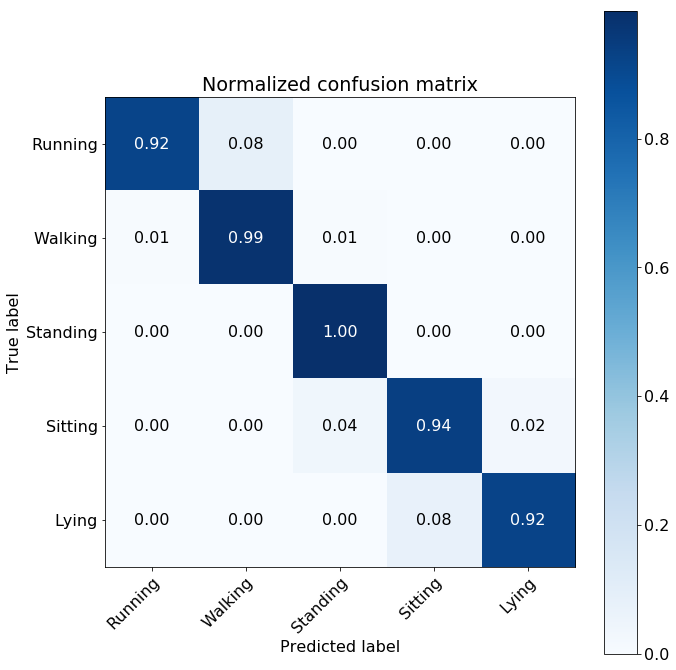

In [24]:
svm_pca_score = cross_val_score(svm_pca_pipeline, all_x, all_y, scoring = 'accuracy', cv = cv_evaluation, n_jobs = -1, verbose = 0)
print(svm_pca_score)
print(svm_pca_score.mean())


svm_pca_predictions = cross_val_predict(svm_pca_pipeline, all_x, all_y, cv = cv_evaluation, n_jobs = -1, verbose = 0)

plot_confusion_matrix(all_y, svm_pca_predictions, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

When applying PCA to the SVM I was able to get an accuracy of 96.3% which is less impressive than using RFE for feature selection as before.  

### Final Model Selection 

From looking at all of the models we have looked at, the model with the highest accuracy was the KNN model with SMOTE applied to data to balance the instances. 

I will take this model and apply the test data files to it 

In [25]:
knn.fit(x_res, y_res.ravel())


print(knn.best_params_, knn.best_score_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 101.4min
[Parallel(n_jobs=-1)]: Done 368 out of 368 | elapsed: 102.5min finished
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\niall\Anaconda3\lib\site-

{'knnclassifier__n_neighbors': 8, 'knnclassifier__weights': 'distance'} 0.9796016898008449


C:\Users\niall\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [26]:
final_pipeline = Pipeline([ 
  ('scaling', StandardScaler()),
  ('feature_selection', RFE(RandomForestClassifier(random_state=0), step = 1, n_features_to_select = 18)),
  ('knnclassifier', KNeighborsClassifier(n_neighbors = 8, weights = 'distance'))
])

final_pipeline.fit(x_res, y_res.ravel())

C:\Users\niall\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

Pipeline(memory=None,
     steps=[('scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('feature_selection', RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, m...i',
           metric_params=None, n_jobs=None, n_neighbors=8, p=2,
           weights='distance'))])

In [27]:
pred1 = final_pipeline.predict(test1)
pred2 = final_pipeline.predict(test2)

np.savetxt("pred1.csv", pred1, delimiter=",")
np.savetxt("pred2.csv", pred2, delimiter=",")

I will now load these final two prediction files into Matlab and save them in the matlab file format to submit